# HSE 2023: Mathematical Methods for Data Analysis

## Homework 3

**Warning 1**: some problems require (especially the lemmatization part) significant amount of time, so **it is better to start early (!)**

**Warning 2**: it is critical to describe and explain what you are doing and why, use markdown cells

In [114]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

## PART 1: Logit model

We consider a binary classification problem. For prediction, we would like to use a logistic regression model. For regularization we add a combination of the $l_2$ and $l_1$ penalties (Elastic Net).

Each object in the training dataset is indexed with $i$ and described by pair: features $x_i\in\mathbb{R}^{K}$ and binary labels $y_i$. The model parametrized with bias $w_0\in\mathbb{R}$ and weights $w\in\mathbb{R}^K$. Note: Bias is included in $w$ vector

The optimization problem with respect to the $w_0, w$ is the following (Logistic loss with Elastic Net regularizers):

$$L(w, w_0) = \sum_{i=1}^{N} -y_i \log{\sigma{(w^\top x_i)}} - (1 - y_i) \log{(1 - \sigma{(w^\top x_i)})} + \gamma \|w\|_1 + \beta \|w\|_2^2$$

#### 1. [0.5 points]  Find the gradient of the Elastic Net loss and write its formulas (better in latex format). Remember what derivative sigmoid has (gradient in fact is a lot simpler than you may get using automatic tools like sympy, matlab or whatever)

##### Put your markdown formulas here
$\nabla (\gamma \|w\|_1 + \beta \|w\|_2^2) = \gamma \, \text{sgn} (w) + 2\beta\ w$

$\frac{\partial L}{\partial w_0} = -\frac{1}{N}\sum_{i=1}^N \frac{y_i \exp(-y_i(w^T x_i + w_0))}{(1 + \exp(-y_i(w^T x_i + w_0)))}$

$\frac{\partial L}{\partial w} = \gamma\ \text{sgn}(w) + 2\beta w -\frac{1}{N}\sum_{i=1}^N \frac{y_i x_i \exp(-y_i(w^T x_i + w_0))}{(1 + \exp(-y_i(w^T x_i + w_0)))}$

#### 2. [0.25 points] Implement the Elastic Net loss (as a function)

In [115]:
def loss(X, y, w: List[float], gamma=1., beta=1.) -> float:
    return np.mean(np.log(1 + np.exp( - y * (X @ w)) )) + np.sum(gamma * np.abs(w) + beta * np.square(w))

#### 3. [0.25 points] Implement the gradient (as a function)

In [116]:
def sigma(x):
    # literally me

    return 1 / (1 + np.exp(-x))

In [117]:
def get_grad(X, y, w: List[float], gamma=1., beta=1.) -> List[float]:
    n, m = X.shape

    M = np.tile((X @ w).reshape(-1, 1), (1, m))
    Y = np.tile(y.reshape(-1, 1), (1, m))
    
    grad_w = gamma * np.sign(w) + 2 * w * beta + (- Y * X / (1 + np.exp(Y * M))).mean(axis=0)

    return grad_w

#### Check yourself

In [118]:
np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
X = np.c_[np.ones(X.shape[0]), X]
y = np.random.binomial(1, 0.42, size=10)
w = np.random.normal(size=5 + 1)

grad_w = get_grad(X, y, w)
assert(np.allclose(grad_w,
                   [-3.99447493, -1.84786723,  0.64520104,  1.67059973, -5.03858487, -5.21496336],
                   rtol=1e+1) # nothing to see here, move along
)

####  4. [1 point]  Implement gradient descent which works for both tol level and max_iter stop criteria and plot the decision boundary of the result

The template provides basic sklearn API class. You are free to modify it in any convenient way.

In [119]:
from sklearn.base import BaseEstimator, ClassifierMixin

In [120]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-3, tolerance=0.01, max_iter=1000, random_state=42):
        self.beta = beta        
        self.gamma = gamma
        self.tolerance= tolerance
        self.max_iter= max_iter
        self.learning_rate = lr
        self.random_state = random_state
        # you may additional properties if you wish
        self.w = None
        self.loss_history = []
        self.alpha = 0.1

   
    def fit(self, X, y):
        # add weights and bias and optimize Elastic Net loss over (X,y) dataset
        # save history of optimization steps
        
        # your code here
        
        np.random.seed(self.random_state)
        previous_w = None
        step = 1
 
        self.w = np.random.uniform(0, 1, size=X.shape[1])
        self.loss_history.append(loss(X, y, self.w, self.gamma, self.beta))
        
        while (previous_w is None or (np.sum(self.w - previous_w)**2) > self.tolerance) and step <= self.max_iter:
            previous_w = self.w
            grad_w = get_grad(X, y, self.w, self.gamma, self.beta)
            
            coeff = 1.0 / (self.alpha * (self.learning_rate + step))

            self.w = self.w - coeff * grad_w
            
            self.loss_history.append(loss(X, y, self.w, self.gamma, self.beta))
            step += 1

        return self
    
    def predict(self, X):
        # return vector of predicted labels (0 or 1) for each object from X
        # your code here
        max_args = np.argmax(self.predict_proba(X), axis=0) 
        predict = np.where(max_args == 1, 1, -1)
        return predict
        
    def predict_proba(self, X):
        # return vector of probabilities for each object from 1
        
        return np.array([1 / (1 + np.exp(np.dot(X, self.w))),\
                         1 / (1 + np.exp(-np.dot(X, self.w)))])

In [121]:
# sample data to test your model
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=180, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

In [122]:
# a function to plot the decision boundary
def plot_decision_boundary(model, X, y):
    fig = plt.figure()
    X1min, X2min = X.min(axis=0)
    X1max, X2max = X.max(axis=0)
    x1, x2 = np.meshgrid(np.linspace(X1min, X1max, 200),
                         np.linspace(X2min, X2max, 200))
    ypred = model.predict(np.c_[x1.ravel(), x2.ravel()])
    ypred = ypred.reshape(x1.shape)

    plt.contourf(x1, x2, ypred, alpha=.4)
    plt.scatter(X[:,0], X[:,1], c=y)

[0.4790780167277521, 0.3704883762964316, 0.3628817546657116, 0.3605580857597494]


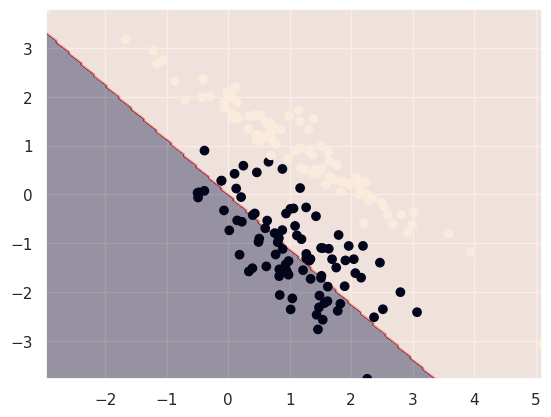

In [123]:
model = Logit(0, 0)
model.fit(X, y)
print(model.loss_history)
plot_decision_boundary(model, X, y)

I'm sure it's OK.

#### 5. [0.25 points] Plot loss diagram for the model, i.e. show the dependence of the loss function from the gradient descent steps

Text(0, 0.5, 'Loss')

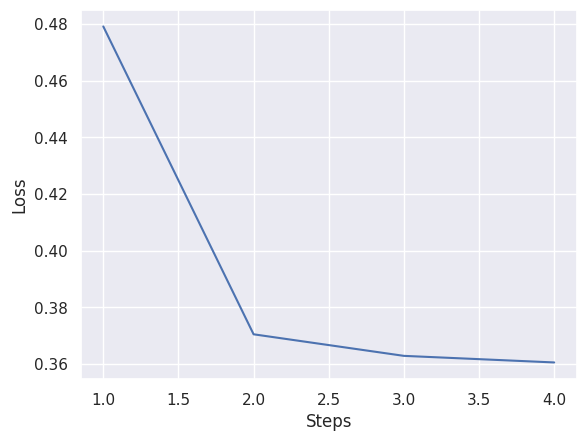

In [124]:
plt.plot(range(1, len(model.loss_history) + 1), model.loss_history)
plt.xlabel("Steps")
plt.ylabel("Loss")

# Something is wrong, I can feel it

## PART 2: Support Vector Machines

#### 6. [2 point] Using the same dataset, train SVM Classifier from Sklearn.
Investigate how different parameters influence the quality of the solution:
+ Try several kernels: Linear, Polynomial, RBF (and others if you wish). Some Kernels have hypermeters: don't forget to try different.
+ Regularization coefficient

Show how these parameters affect accuracy, roc_auc and f1 score.
Make plots for the dependencies between metrics and parameters.
Try to formulate conclusions from the observations. How sensitive are kernels to hyperparameters? How sensitive is a solution to the regularization? Which kernel is prone to overfitting?

In [125]:
# your code here
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

# Leave all at default, except kernel and tested param
def plot_kernel(kernel, params, X, y):
    fig, axes = plt.subplots(nrows=len(params), ncols=1, figsize=(20, 16))

    for ax, param in zip(axes, params.items()):
        param_name, param_options = param

        acc_list = []
        roc_auc_list = []
        f1_list = []

        for param_option in param_options:
            model_params = {
                "kernel": kernel,
                "random_state": 42,
                param_name: param_option,
            }

            model = SVC(**model_params)
            model.fit(X, y)

            pred_y = model.predict(X)

            acc_list.append(accuracy_score(y, pred_y))
            roc_auc_list.append(roc_auc_score(y, pred_y))
            f1_list.append(f1_score(y, pred_y))

        param_options = [str(x) for x in param_options]

        ax.set_xticks(np.linspace(0, len(param_options), min(5, len(param_options) + 1)))

        ax.plot(param_options, acc_list, label="accuracy_score", dashes=[4, 4])
        ax.plot(param_options, roc_auc_list, label="roc_auc_score", dashes=[4, 4])
        ax.plot(param_options, f1_list, label="f1_score", dashes=[4, 4])
        ax.legend()

        ax.set_title(param_name)



In [126]:
X, y = make_classification(n_samples=180, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

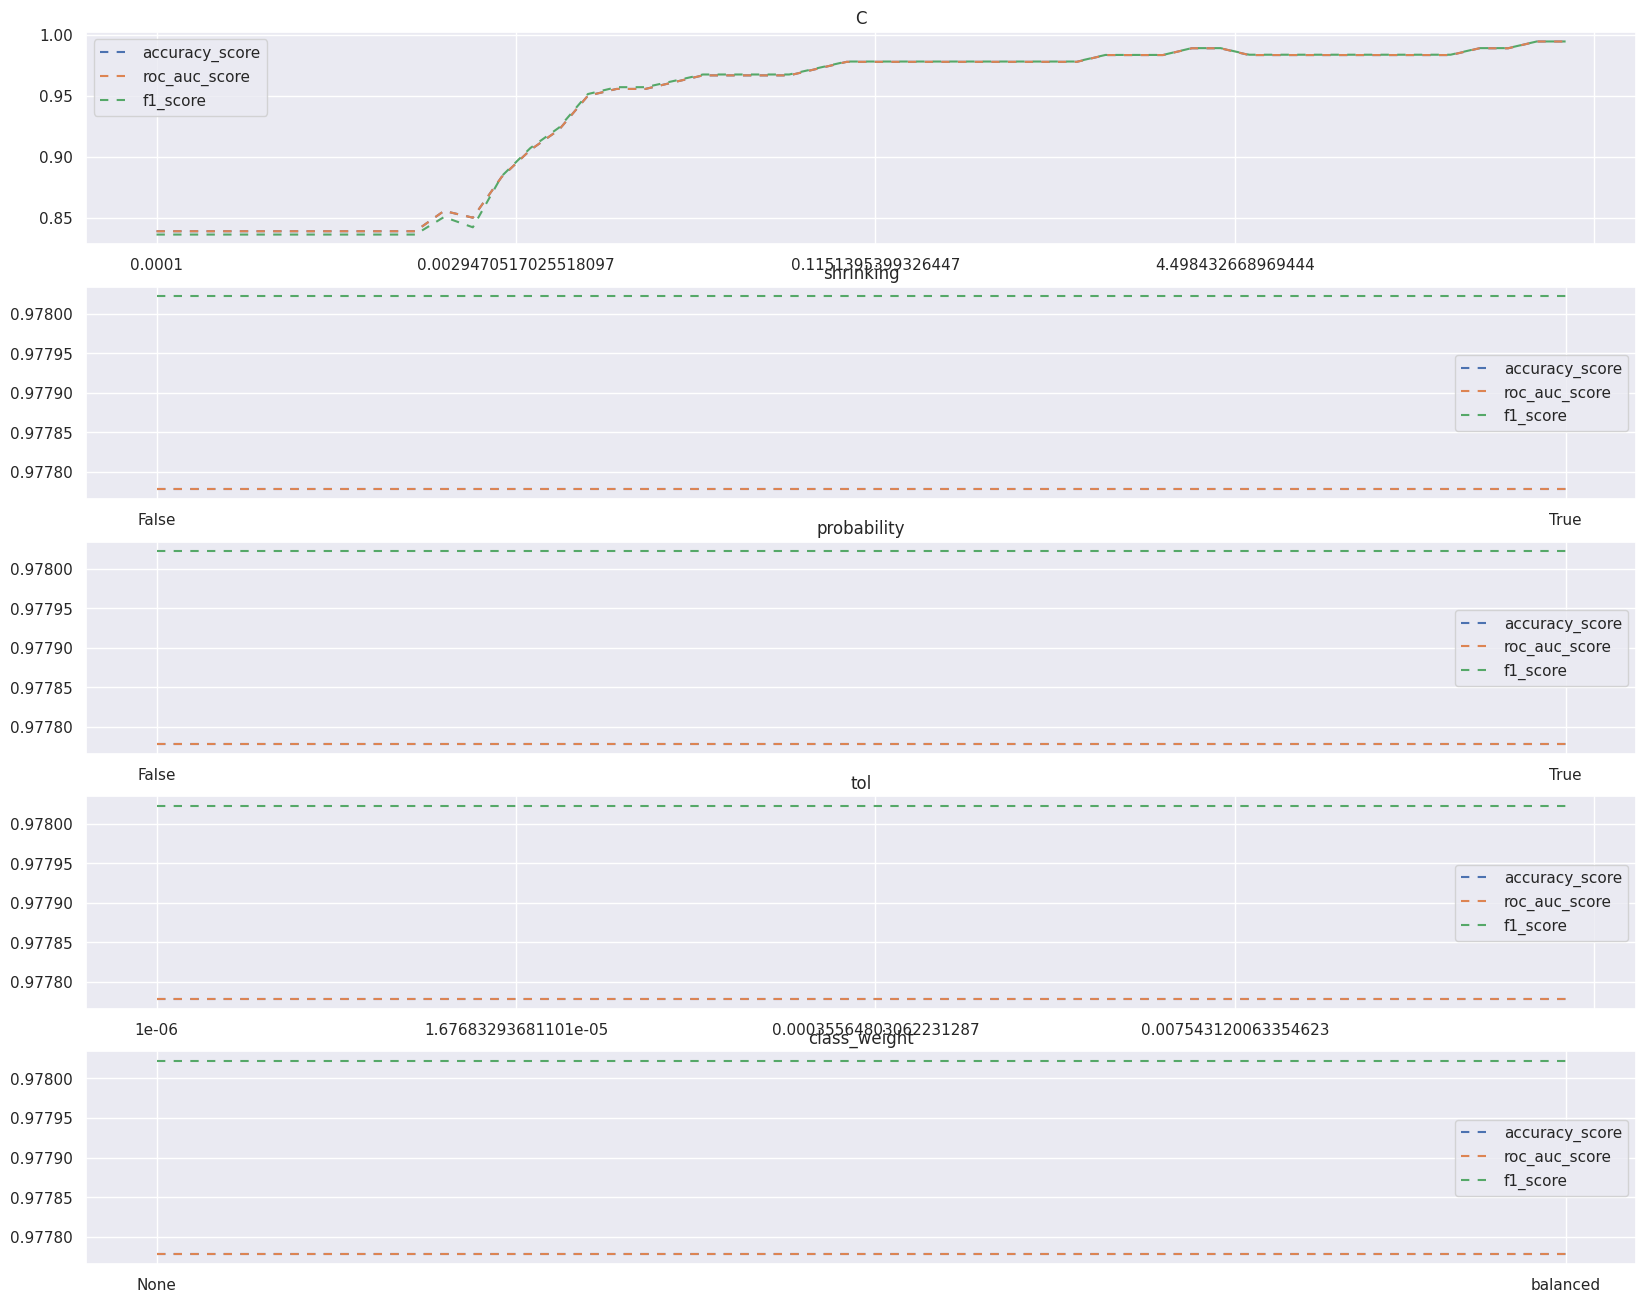

In [127]:
plot_kernel(
    "linear",
     {
        "C": np.logspace(-4, 2, 50),
        "shrinking": [False, True],
        "probability": [False, True],
        "tol": np.logspace(-6, -1, 50),
        "class_weight": [None, "balanced"],
     },
     X,
     y,
    )

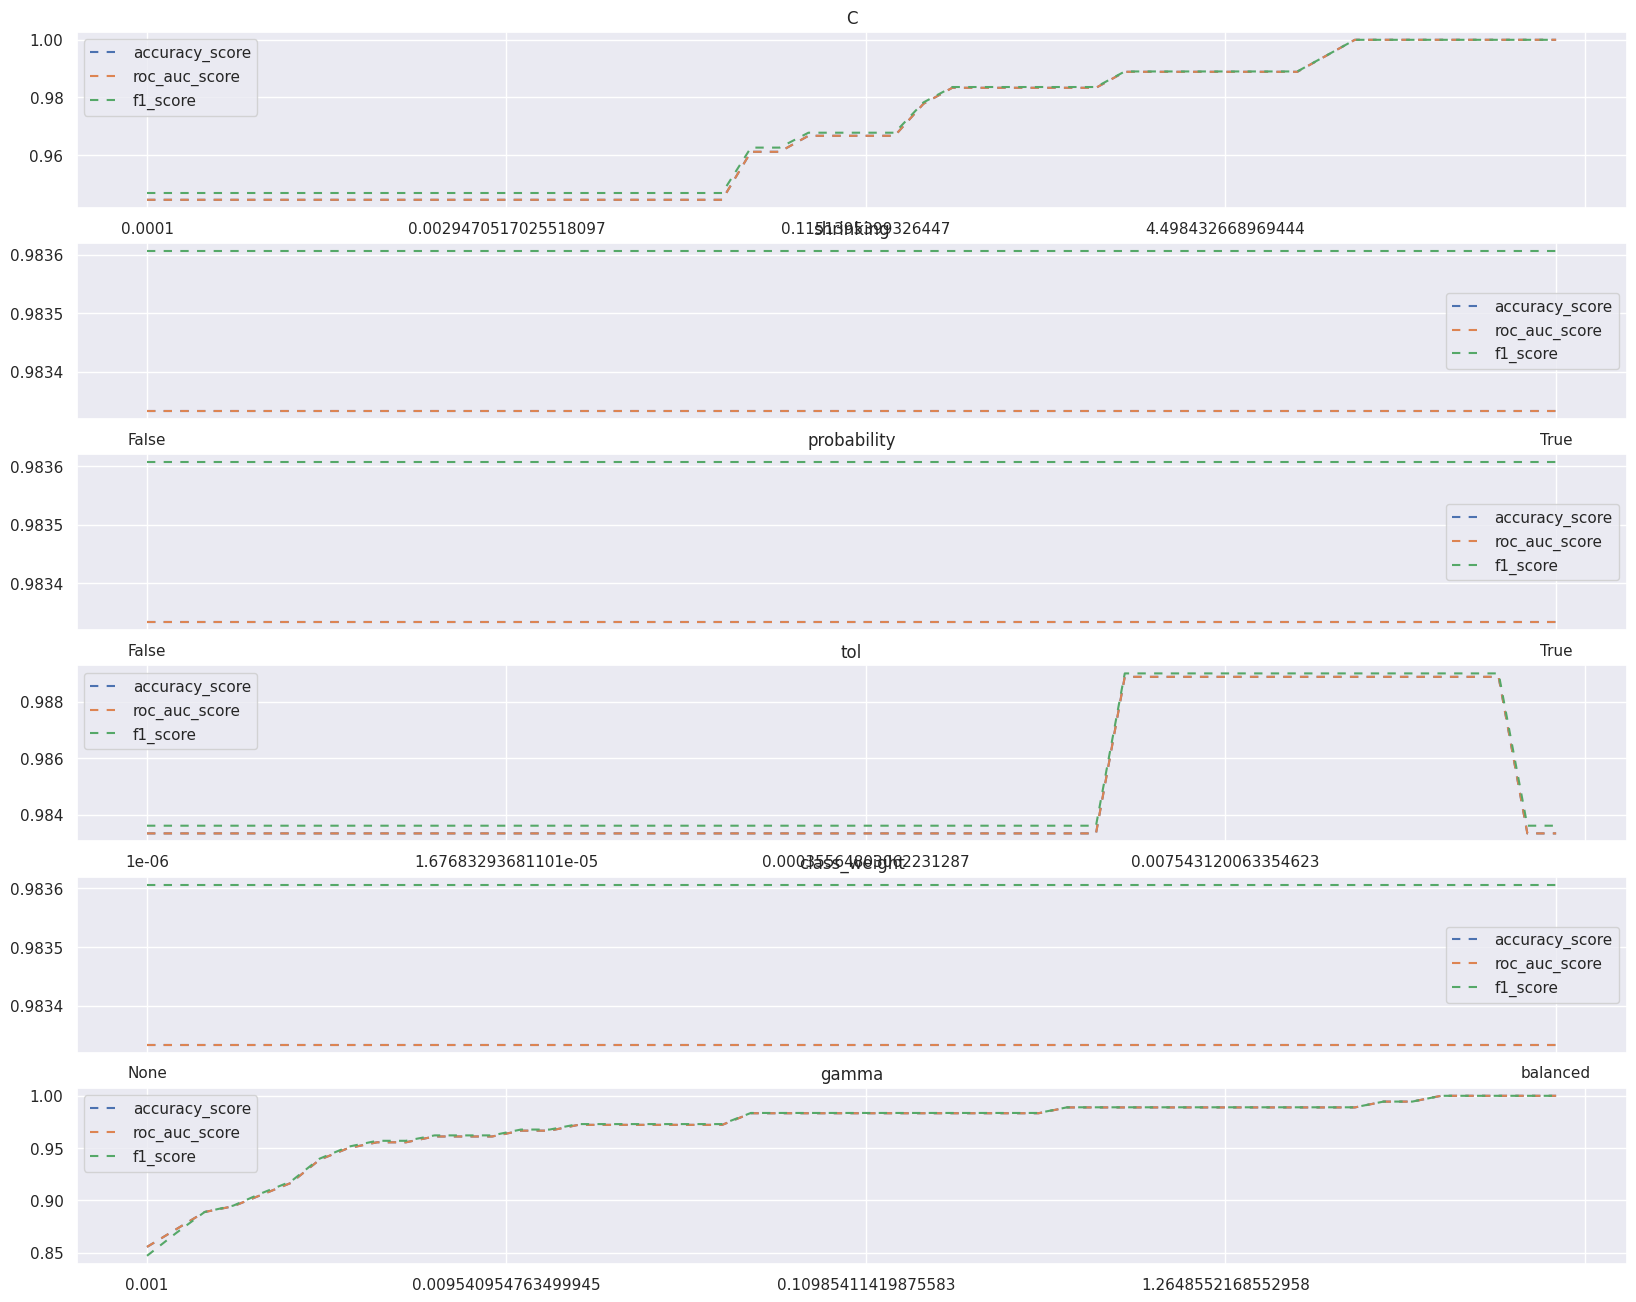

In [128]:
plot_kernel(
    "rbf",
     {
        "C": np.logspace(-4, 2, 50),
        "shrinking": [False, True],
        "probability": [False, True],
        "tol": np.logspace(-6, -1, 50),
        "class_weight": [None, "balanced"],
        "gamma": np.logspace(-3, 1, 50),
     },
     X,
     y,
    )

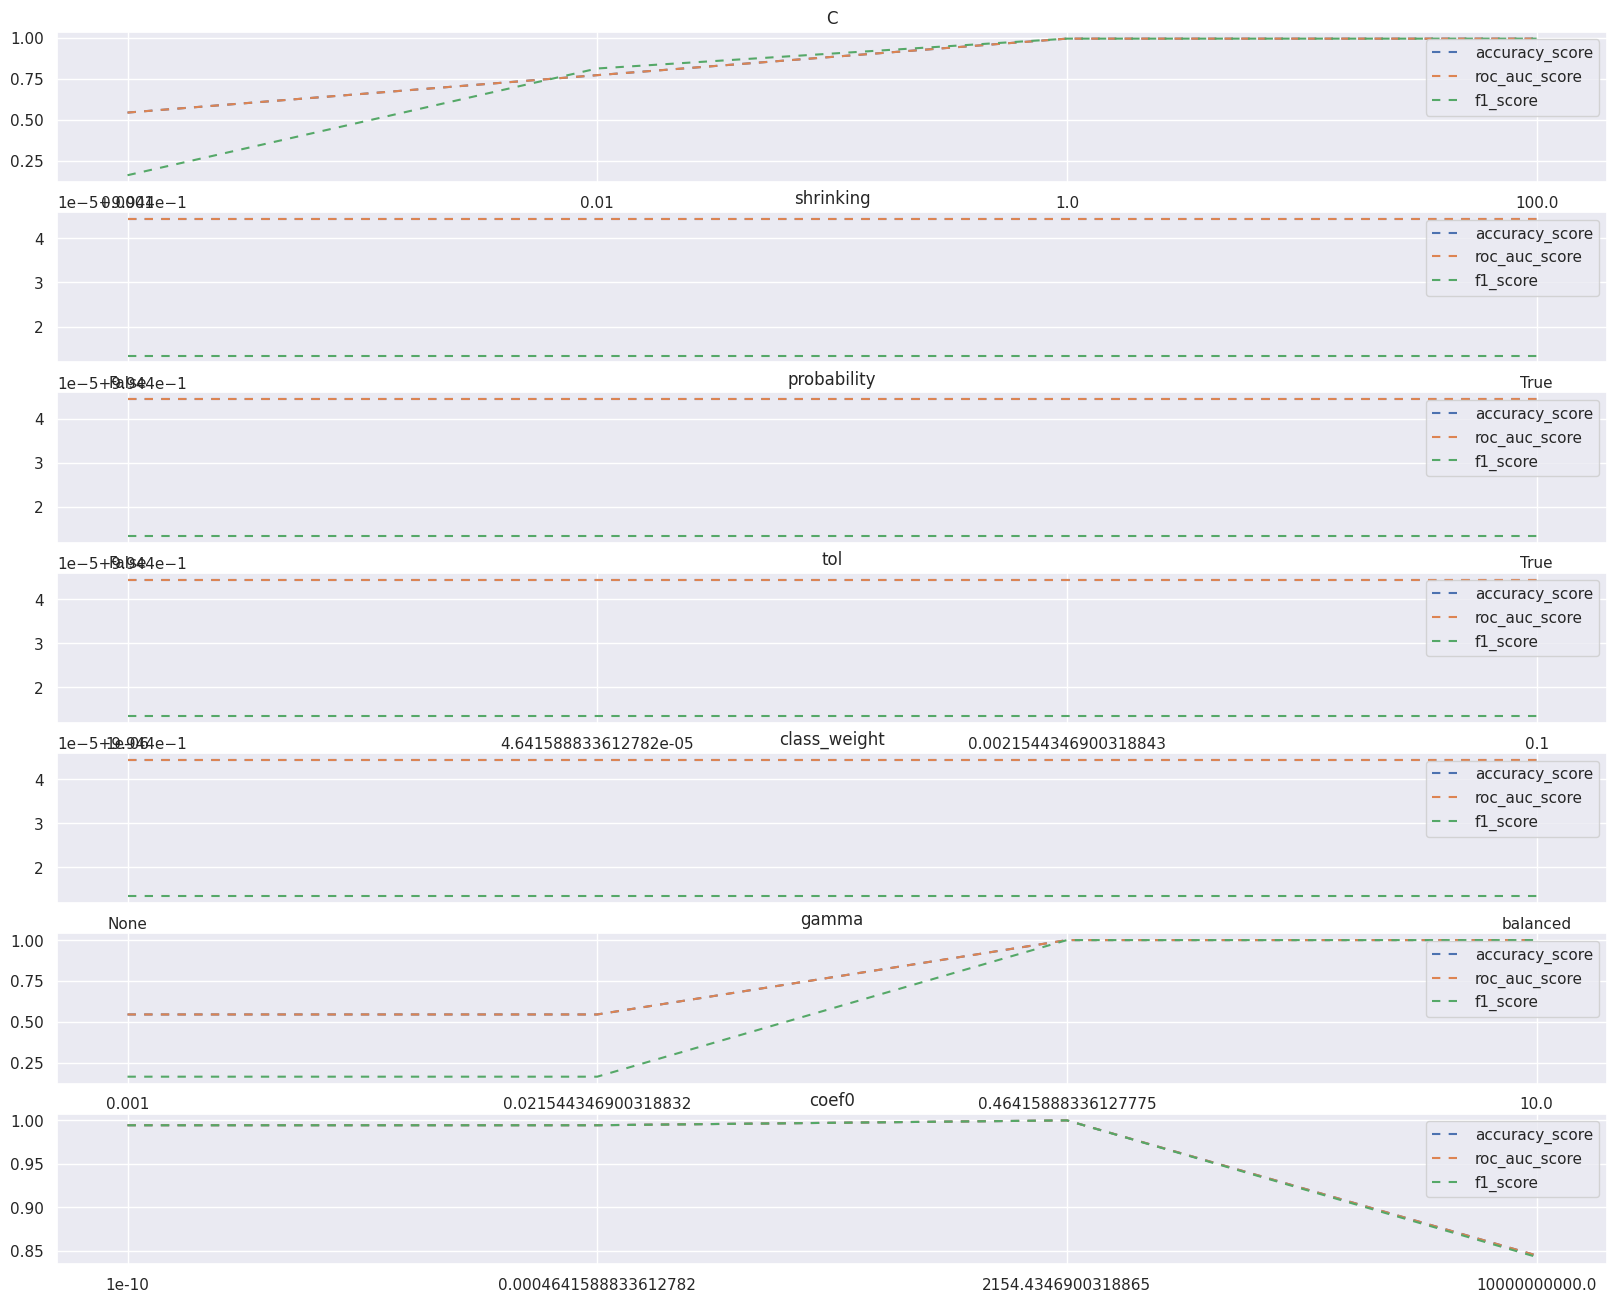

In [129]:
plot_kernel(
    "poly",
     {
        "C": np.logspace(-4, 2, 4), # Decrease variable number because it's stupidly slow
        "shrinking": [False, True],
        "probability": [False, True],
        "tol": np.logspace(-6, -1, 4),
        "class_weight": [None, "balanced"],
        "gamma": np.logspace(-3, 1, 4),
        "coef0": np.logspace(-10, 10, 4),
     },
     X,
     y,
    )

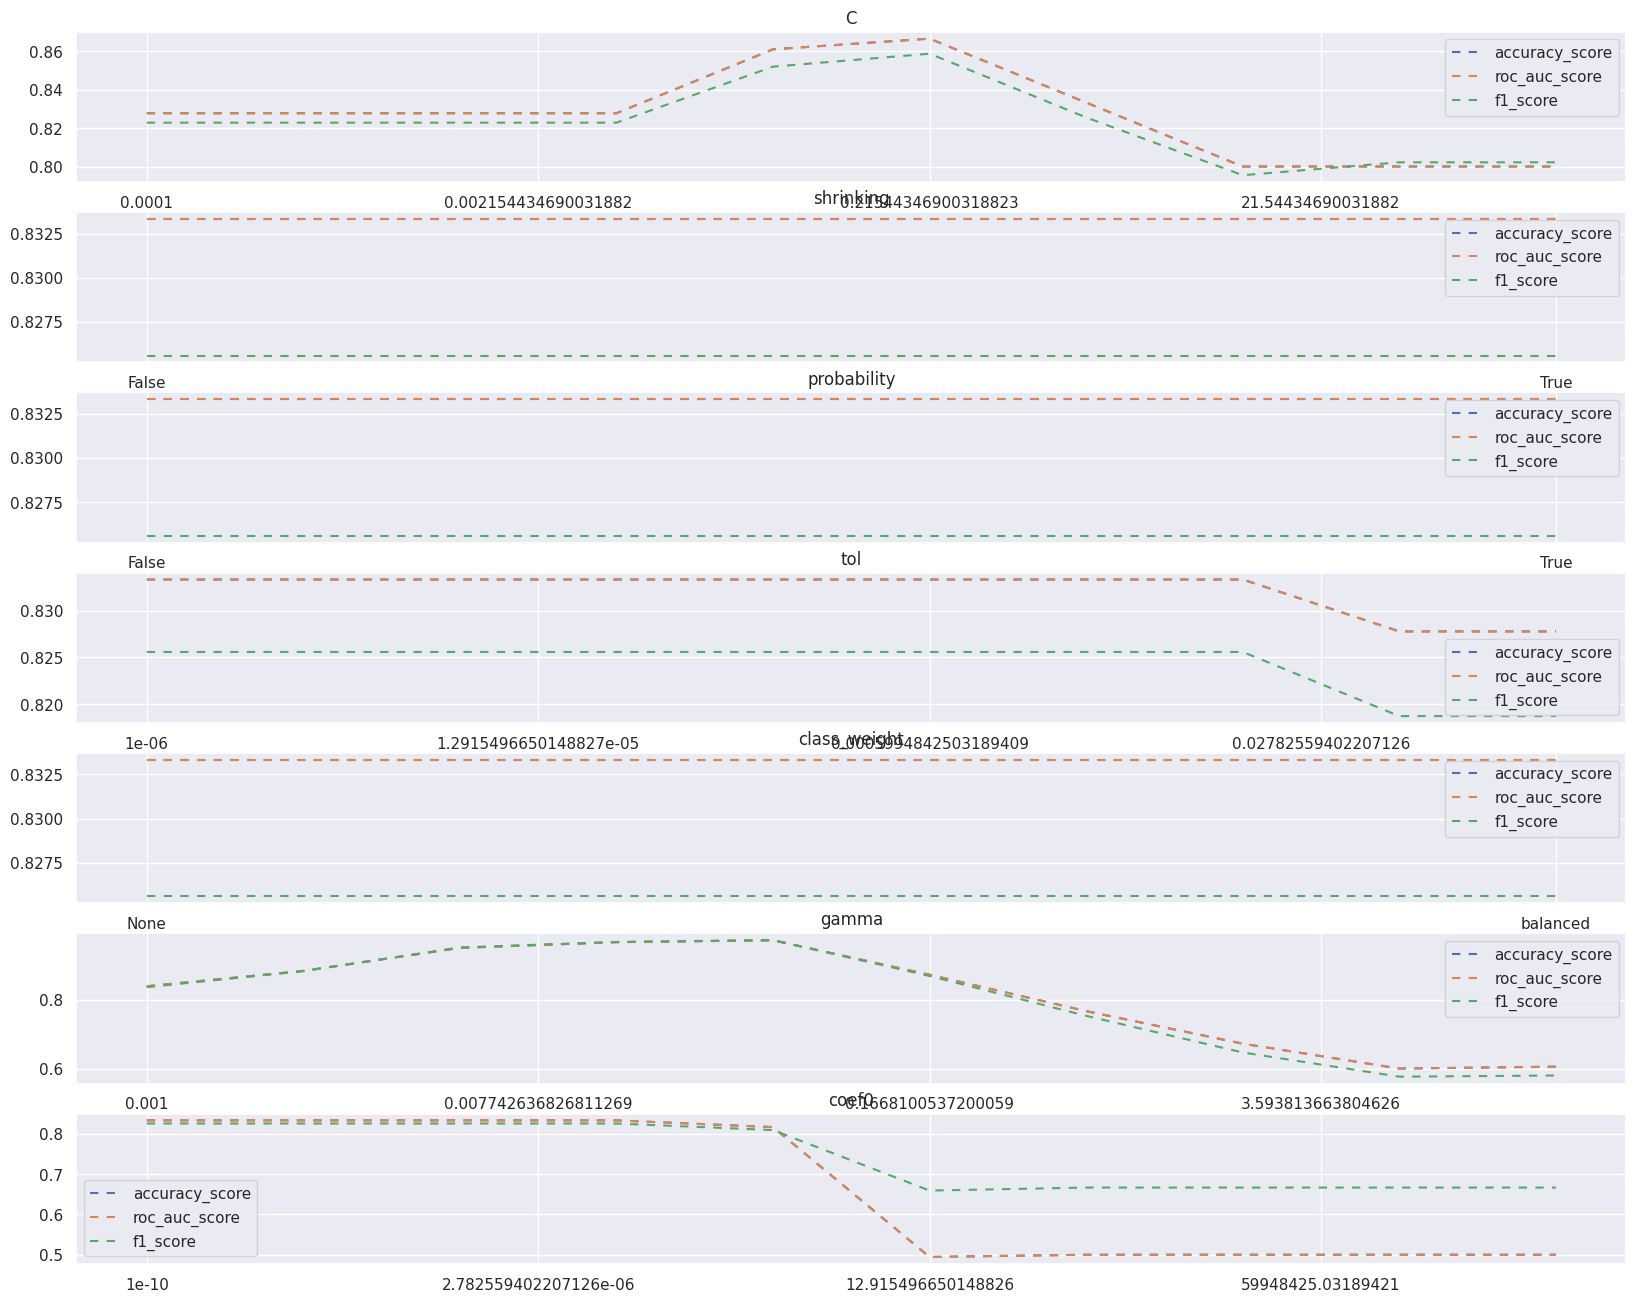

In [130]:
plot_kernel(
    "sigmoid",
     {
        "C": np.logspace(-4, 2, 10),
        "shrinking": [False, True],
        "probability": [False, True],
        "tol": np.logspace(-6, -1, 10),
        "class_weight": [None, "balanced"],
        "gamma": np.logspace(-3, 1, 10),
        "coef0": np.logspace(-10, 10, 10),
     },
     X,
     y,
    )

 Самые важные параметры - C и gamma (где применимо). Poly/Sigmoid заметно чувствительнее к гиперпараметрам, чем linear/rbf. Linear наименее подвержен переобучению, poly - заметно сильнее.

## PART 3: Natural Language Processing

#### 7. [1.75 point] Form the dataset

We are going to form a dataset that we will use in the following tasks for binary and multiclass classification

0. Choose **six** authors that you like (specify who you've chosen) and download the <a href="https://www.kaggle.com/d0rj3228/russian-literature?select=prose">relevant data</a> from **prose** section
1. Build your own dataset for these authors:
    * divide each text into sentences such that we will have two columns: *sentence* and *target author*, each row will contain one sentence and one target
    * drop sentences where N symbols in a sentence < 15
    * fix random state and randomly choose sentences in the folowing proportion "5k : 15k : 8k : 11k : 20k : 3k" for the authors respectively
    
    sample data may look like:
    
    <center>
    <table>
        <tr>
            <th> sentence </th>
            <th> author </th>
        </tr>
        <tr><td> Несколько лет тому назад в одном из своих поместий жил старинный русской барин, Кирила Петрович Троекуров. </td><td> Пушкин </td><td>
        <tr><td> Уже более недели приезжий господин жил в городе, разъезжая по вечеринкам и обедам и таким образом проводя, как говорится, очень приятно время. </td><td> Гоголь </td><td>
        <tr><td> ... </td><td> ... </td><td>
        <tr><td> Я жил недорослем, гоняя голубей и играя в чехарду с дворовыми мальчишками. </td><td> Пушкин </td><td>         
    </table>
</center>
     
2. Preprocess (tokenize and clean) the dataset
    * tokenize, remove all stop words (nltk.corpus.stopwords), punctuation (string.punctuation) and numbers
    * convert to lower case and apply either stemming or lemmatization of the words (on your choice)
    * vectorize words using both **bag of words** and **tf-idf** (use sklearn)
    * observe and describe the difference between vectorized output (what do numbers look like after transformations and what do they represent?)

In [131]:
# привет тем кто сделал датасет в виде zip-архива с именами в кодировке древних славян

import os
import random

def read_author(author, count):
    all_sentences = []

    for book in os.listdir(f"data/{author}/"):
        book_sentences = []
 
        with open(f'data/{author}/{book}', "r") as file:
            for data in file:
                sentences = data.split('.')
                for sentence in sentences:
                    if len(sentence) >= 15:
                        book_sentences.append([author, sentence.strip()])

        all_sentences.extend(book_sentences)

    return random.choices(all_sentences, k=count)

def read_dataset(authors, authors_proportion):
    np.random.seed(42)
    df = pd.DataFrame(columns=["author", "sentence"])

    for author, proportion in zip(authors, authors_proportion):
        new_df = pd.DataFrame(read_author(author, proportion), columns=['author', 'sentence'])

        df = pd.concat([df, new_df])
            
    return df

In [132]:
authors = os.listdir("data")
authors_proportion = [5000, 15000, 8000, 11000, 20000, 3000]
data = read_dataset(authors, authors_proportion)

In [133]:
data.head()

,author,sentence
0,Turgenev,"– Глинку вы, стало быть, тоже на признаете?"
1,Turgenev,"Привели голубчика… ""Как же это ты так, говорю,..."
2,Turgenev,– Нет – или погодите – есть
3,Turgenev,"Он и прежде изъявил желание иметь ее при себе,..."
4,Turgenev,Она осталась печальной и озабоченной до самого...


In [134]:
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
import string
import nltk

In [135]:
tokenizer = WordPunctTokenizer()

nltk.download('stopwords')
stop_words = stopwords.words('russian')

[nltk_data] Downloading package stopwords to /home/keddad/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [136]:
def tokenize(text: str):
    return tokenizer.tokenize(text)

def clear(sentence):
    words = [word for word in sentence if not (word in stop_words or word.isdigit() or word in string.punctuation or word == "–")]
    return words

def process_column(column: pd.Series):
    return column.apply(lambda s: clear(tokenize(s.lower())))

In [137]:
data = data.apply(lambda x: process_column(x) if x.name == 'sentence' else x)
data.head()

,author,sentence
0,Turgenev,"[глинку, стало, признаете]"
1,Turgenev,"[привели, голубчика, …, это, говорю, друг, fol..."
2,Turgenev,[погодите]
3,Turgenev,"[прежде, изъявил, желание, иметь, татьяна, отк..."
4,Turgenev,"[осталась, печальной, озабоченной, самого, веч..."


In [138]:
import pymorphy3

In [139]:
morph_analyzer = pymorphy3.MorphAnalyzer()

data = data.apply(lambda x: x.apply(lambda sentence: [morph_analyzer.parse(word)[0].normal_form for word in sentence]) if x.name == 'sentence' else x)
data.head()

,author,sentence
0,Turgenev,"[глинка, стать, признать]"
1,Turgenev,"[привести, голубчик, …, это, говорить, друг, f..."
2,Turgenev,[погодить]
3,Turgenev,"[прежде, изъявить, желание, иметь, татьяна, от..."
4,Turgenev,"[остаться, печальный, озаботить, сам, вечер]"


In [140]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [141]:
text = data.sentence.map(' '.join)

In [142]:
# Bag of words

vectorizer = CountVectorizer(max_features = 42)
vectorizer.fit(text)

X_cv = vectorizer.transform(text)
X_cv.todense()[:5]

matrix([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [143]:
# Tf-idf

tfidf_vectorizer = TfidfVectorizer(max_features = 42)
tfidf_vectorizer.fit(text)

X_tfidf = tfidf_vectorizer.transform(text)
X_tfidf.todense()[:5]

matrix([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         1.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.77357028, 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.52753917,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,


Bag of words просто высчитывает количество вхождений слов. Значения, соответственно, целочисленные.

TF-IDF смотрит на отношение Term Frequency и Inverse Document Frequency соответственно, поэтому числа дробные.

###  Binary classification

#### 8. [2 point] Train model using Logistic Regression (your own) and SVC (SVM can be taken from sklearn)

* choose *two* authors from the dataset that you have formed in the previous task
* check the balance of the classes
* divide the data into train and test samples with 0.7 split rate (don't forget to fix the random state)
* using GridSearchCV - find the best parameters for the models (by F1 score) and use it in the next tasks
* make several plots to address the dependence between F1 score and parameters
* plot confusion matrix for train and test samples
* compute some relevant metrics for test sample (useful to check the seminars 5 and 6, use sklearn)
* make conclusions about the performance of your models


In [144]:
from collections import Counter

authors = ['Gorky', 'Gogol'] # GG

I_raw = np.isin(data.author, authors)

y = data.author[I_raw]
Counter(y)

# Ожидаемо, 15:11

Counter({'Gorky': 15000, 'Gogol': 11000})

In [145]:
y = y.replace({"Gorky": 1, "Gogol": -1}).to_numpy()

In [146]:
X_raw = text[I_raw].to_numpy()
print(X_raw.shape)

(26000,)


In [147]:
X_raw.shape, y.shape

((26000,), (26000,))

In [148]:
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [149]:
transformer = Pipeline([
    ('tf_idf', TfidfVectorizer()),
    ('truncated_svd', TruncatedSVD(random_state=42)),
    ('std_scaler', StandardScaler())
]) 

X = transformer.fit_transform(X_raw, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

In [150]:
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [151]:
# Train our homebrew
logit = Logit(0.1, 0.1)

logit.fit(X_train, y_train)
y_train_pred_log = logit.predict(X_train)
y_test_pred_log = logit.predict(X_test)

In [152]:
# fix me
#parameters = {
#    'beta': [0.0, 0.5, 1.0],
#    'gamma': [0.0, 0.5, 1.0],
#    'learning_rate': [1e-3, 1e-5, 1e-8],
#    'tolerance': [1e-9, 1e-8, 1e-5, 1e-3],
#}

#clflogit = GridSearchCV(logit, parameters, scoring = 'f1')
#clflogit.fit(X_train, y_train)

#pred = clflogit.predict(X_test)
#proba  = clflogit.predict_proba(X_test)

#print(clflogit.best_params_)

In [153]:
def plot_mean_scores(results, params, ncols=2, nrows=1):
    tests = results['params']
    scores = results['mean_test_score']
    
    ans = []
    for parameter in params:
        parameter = parameter
        m_scores = {}
        for i, test in enumerate(tests):
            val = test[parameter]
            if val in m_scores:
                m_scores[val].append(scores[i])
            else:
                m_scores[val] = [scores[i]]
        ans.append((m_scores.keys(), list(map(np.mean, m_scores.values()))))

    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(16, 8))

    if type(axs) != np.ndarray:
        axs = [axs]
    
    for ax, vals, title in zip(axs, ans, params):
        ax.set_title(title)
        ax.set_xticklabels(labels=vals[0])
        ax.set_xticks(ticks=np.arange(len(vals[1])))
        ax.plot(np.arange(len(vals[1])), vals[1])
        
    plt.show()

In [154]:
svc = SVC()
svc.fit(X_train, y_train)
y_train_pred_svc = svc.predict(X_train)
y_test_pred_svc = svc.predict(X_test)

In [155]:
parameters = {
    'gamma': ['auto', 'scale'], # Removed some params because it was taking too long
    'C': [10, 100, 1000],
}

clf = GridSearchCV(
    estimator=svc,
    scoring='f1', 
    param_grid=parameters,
)

clf.fit(X_train, y_train)

print(clf.best_params_)

{'C': 10, 'gamma': 'scale'}


/tmp/ipykernel_54251/3812685641.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=vals[0])
/tmp/ipykernel_54251/3812685641.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=vals[0])


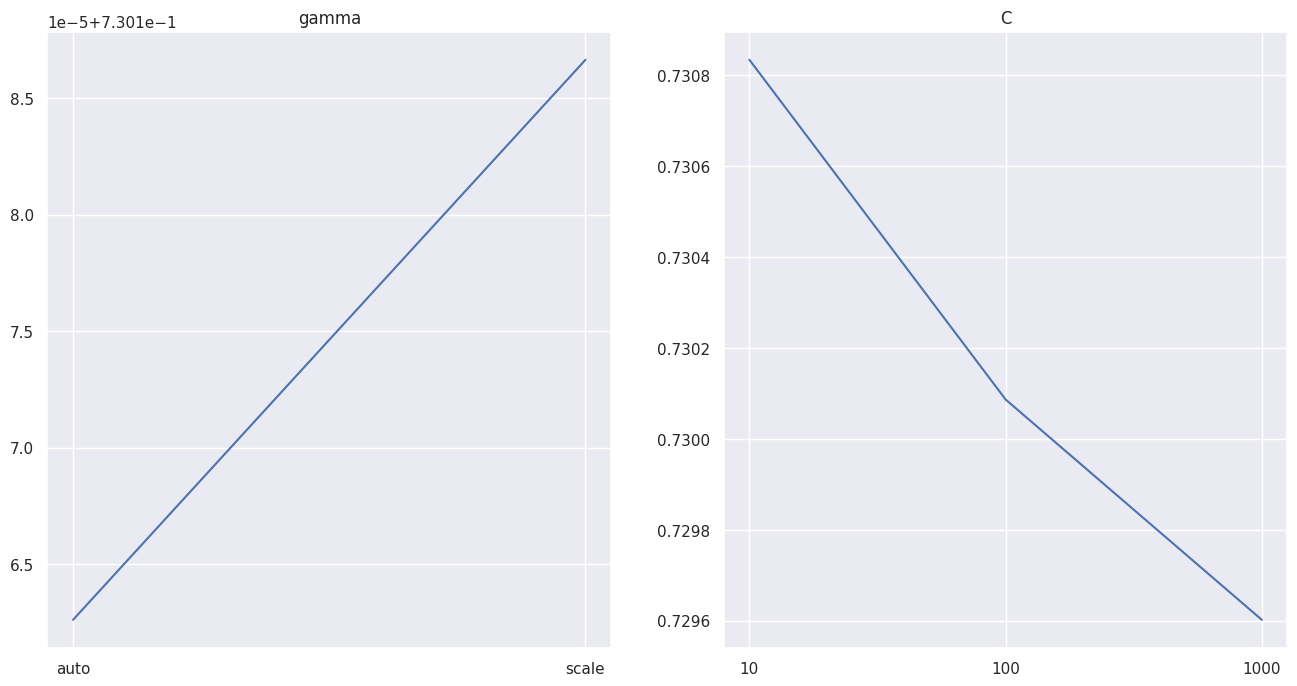

In [156]:
plot_mean_scores(clf.cv_results_, ['gamma', 'C'])

In [157]:
logit = Logit(0,0)
logit.fit(X_train, y_train)

y_train_pred_log = logit.predict(X_train)
y_test_pred_log = logit.predict(X_test)

svc = SVC(C=100, gamma='auto')
svc.fit(X_train, y_train)

y_train_pred_svc = svc.predict(X_train)
y_test_pred_svc = svc.predict(X_test)

[[4995 2686]
 [6925 3594]]
[[2176 1143]
 [2917 1564]]
[[  439  7242]
 [  264 10255]]
[[ 175 3144]
 [ 116 4365]]


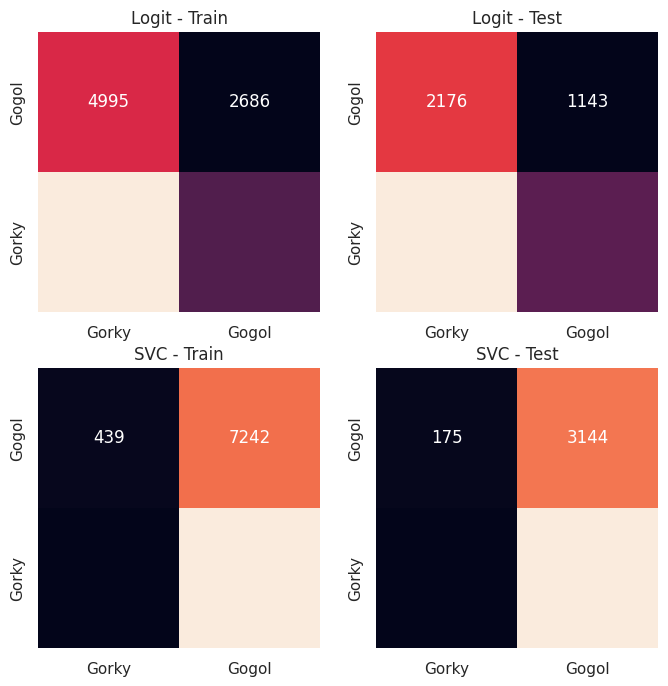

In [163]:
lst = [
    (y_train, y_train_pred_log, 'Logit - Train'),
    (y_test, y_test_pred_log, 'Logit - Test'),
    (y_train, y_train_pred_svc, 'SVC - Train'),
    (y_test, y_test_pred_svc, 'SVC - Test'),
]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

for ax, (y_real, y_pred, label) in zip(np.ravel(axes), lst):
    # https://github.com/mwaskom/seaborn/issues/619 leads to information missing from graphs on my machine
    # Duplicate them in text
    print(confusion_matrix(y_real, y_pred))
    sns.heatmap(ax=ax, data=confusion_matrix(y_real, y_pred),
                annot=True, fmt="d", cbar=False, xticklabels=authors, yticklabels=list(reversed(authors)))

    ax.set_title(label)

plt.show()

Поймать баг с рендерингом графиков было неприятно. В целом очевидно что моя модель работает значительно хуже, там наверняка есть проблемы с имплементацией. При этом SVC тоже работает не очень хорошо - возможно, есть проблемы с обработкой данных?

In [159]:
def metrics(test_y, pred, proba):
    print("Precision: {0:6.2f}".format(precision_score(test_y, pred, average='macro')))
    print("Recall: {0:6.2f}".format(recall_score(test_y, pred, average='macro')))
    print("F1-measure: {0:6.2f}".format(f1_score(test_y, pred, average='macro')))
    print("Accuracy: {0:6.2f}".format(accuracy_score(test_y, pred)))
    print("ROC-AUC  =  {0:6.2f}".format(roc_auc_score(test_y, proba, multi_class='ovo')))



logit = Logit(0, 0)
logit.fit(X_train, y_train)
y_train_pred_log = logit.predict(X_train)
y_test_pred_log = logit.predict(X_test)

proba_log  = logit.predict_proba(X_test)
print("Homebrew logit:")
metrics(y_test, y_test_pred_log, proba_log[1,:])

svc = SVC(C=1000, gamma='auto', probability=True)
svc.fit(X_train, y_train)
y_train_pred_svc = svc.predict(X_train)
y_test_pred_svc = svc.predict(X_test)


proba_svc  = svc.predict_proba(X_test)
print("SVC:")
metrics(y_test, y_test_pred_svc, proba_svc[:,1])

Homebrew logit:
Precision:   0.50
Recall:   0.50
F1-measure:   0.48
Accuracy:   0.48
ROC-AUC  =    0.50
SVC:
Precision:   0.59
Recall:   0.51
F1-measure:   0.41
Accuracy:   0.58
ROC-AUC  =    0.57


#### 9. [1 point] Analysing ROC AUC

It is possible to control the proportion of statistical errors of different types using different thresholds for choosing a class. Plot ROC curves for Logistic Regression and SVC, show the threshold on ROC curve plots. Choose such a threshold that your models have no more than 30% of false positive errors rate. Pay attention to `thresholds` parameter in sklearn roc_curve

In [160]:
# your code here

### Multiclass logit

#### 10. [1 point] Take the One-VS-One classifier (use sklearn) and apply to Logit model (one you've made in the 4th task) in order to get multiclass linear classifier

*It is possible to use sklearn model instead of your own one but with a penalty of 0.5*

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsOneClassifier.html">OneVsOneClassifier</a>

* use the data you got at the previous step for 6 authors
* divide the data into train and test samples with 0.7 split rate
* using GridSearchCV - find the best parameters for the models (by F1 score)
* plot confusion matrix for train and test samples
* compute relevant metrics for test sample (use sklearn)

In [161]:
# your code here